In [616]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import argparse
import os
import json
import shutil
import cv2
from tqdm import tqdm
import time

In [617]:
trans = transforms.Compose([
    transforms.Resize((105,105)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.ImageFolder(root="./flatfish/train", transform=trans)
validset = torchvision.datasets.ImageFolder(root="./flatfish/validation", transform=trans)
testset = torchvision.datasets.ImageFolder(root="./flatfish/test", transform=trans)

In [618]:
#18번째 데이터 확인, -1부터 1 사이 값으로 정규화된 것을 확인할 수 있음. 라벨값은 0
trainset.__getitem__(1)

(tensor([[[-0.0510, -0.0588, -0.0980,  ..., -0.8275, -0.8431, -0.7098],
          [-0.0588, -0.0588,  0.0510,  ..., -0.7804, -0.7961, -0.6078],
          [-0.0588, -0.0196,  0.3490,  ..., -0.7961, -0.7961, -0.6706],
          ...,
          [ 0.2392,  0.2000,  0.1765,  ..., -0.8510, -0.8902, -0.8824],
          [ 0.1686,  0.1686,  0.1529,  ..., -0.8902, -0.9216, -0.8980],
          [ 0.1216,  0.1294,  0.1451,  ..., -0.8902, -0.9216, -0.9059]]]),
 0)

In [619]:
#trainset 개수 확인
print(len(trainset), len(validset), len(testset))

14 6 6


In [620]:
#양식(farmed)과 자연산(natural) 클래스 구분
classes = trainset.classes
classes

['farmed', 'natural']

In [621]:
train_loader = DataLoader(trainset, batch_size = len(trainset), shuffle = True, num_workers = 4)
valid_loader = DataLoader(validset, batch_size = len(validset), shuffle = True, num_workers = 4)
test_loader = DataLoader(testset, batch_size = len(testset), shuffle = True, num_workers = 4)

In [622]:
dataiter = iter(train_loader)
train_images, train_labels = dataiter.next()
dataiter = iter(valid_loader)
valid_images, valid_labels = dataiter.next()
dataiter = iter(test_loader)
test_images, test_labels = dataiter.next()

In [623]:
print(train_labels, valid_labels, test_labels)

tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0]) tensor([1, 1, 0, 0, 0, 1]) tensor([1, 1, 1, 0, 0, 0])


In [624]:
#배치사이즈, RGB, 가로길이, 세로길이
print(train_images.shape)
print(valid_images.shape)
print(test_images.shape)

torch.Size([14, 1, 105, 105])
torch.Size([6, 1, 105, 105])
torch.Size([6, 1, 105, 105])


In [625]:
def imshow(img):
    img = img + 0.5 #unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)), cmap='gray')
    
    print((np.transpose(np_img, (1,2,0))))

[[[0.39411765]
  [0.4019608 ]
  [0.40980393]
  ...
  [0.3392157 ]
  [0.33137256]
  [0.66078436]]

 [[0.38627452]
  [0.4019608 ]
  [0.40980393]
  ...
  [0.4019608 ]
  [0.3392157 ]
  [0.6215687 ]]

 [[0.38627452]
  [0.4019608 ]
  [0.40980393]
  ...
  [0.3627451 ]
  [0.3392157 ]
  [0.61372554]]

 ...

 [[0.20588237]
  [0.20588237]
  [0.18235296]
  ...
  [0.3627451 ]
  [0.3627451 ]
  [0.6294118 ]]

 [[0.19803923]
  [0.1901961 ]
  [0.16666669]
  ...
  [0.37058824]
  [0.3627451 ]
  [0.6294118 ]]

 [[0.17450982]
  [0.16666669]
  [0.14313728]
  ...
  [0.3627451 ]
  [0.3627451 ]
  [0.6294118 ]]]


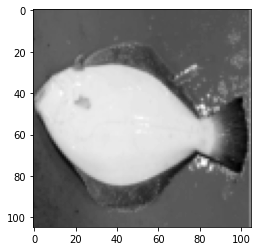

In [626]:
imshow(train_images[2])

In [627]:
class SiameseNet(nn.Module):
    
    def __init__(self):
        super(SiameseNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(inplace=True),  # 128@42*42
            nn.MaxPool2d(2),  # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(inplace=True),  # 128@18*18
            nn.MaxPool2d(2),  # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(inplace=True),  # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Sequential(nn.Linear(4096, 1), nn.Sigmoid())

        # weight init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.normal_(m.bias, mean=0.5, std=0.01)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.01)
                nn.init.normal_(m.bias, mean=0.5, std=0.01)

    def sub_forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)

        # score the similarity between the 2 encodings
        scores = self.out(diff)

        # return scores (without sigmoid) and use bce_with_logit
        # for increased numerical stability
        return scores

In [628]:
model = SiameseNet()

In [629]:
# Define your execution device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print("The model will be running on", device, "device\n") 
model.to(device)    # Convert model parameters and buffers to CPU or Cuda 

The model will be running on cpu device



SiameseNet(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [630]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.count = 0
        self.sum = 0
        self.avg = 0
        self.val = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        wrong_k = batch_size - correct_k
        res.append(wrong_k.mul_(100.0 / batch_size))

    return res
    # return res, pred[:1].squeeze(0)


def save_checkpoint(state, is_best):
    if is_best:
        filename='./best_model.pt'
    else:
        filename=f'./model_ckpt{state["epoch"]}.pt'
    
    torch.save(state, filename)

    
def load_checkpoint(best):
    if best:
        model_path = './best_model.pt'
    else:
        model_path = sorted(glob('./models/model_ckpt_*.pt'), key=len)[-1]

    ckpt = torch.load(model_path)

    if best:
        print(
            f"Loaded {os.path.basename(model_path)} checkpoint @ epoch {ckpt['epoch']} with best valid acc of {ckpt['best_valid_acc']:.3f}")
    else:
        print(f"Loaded {os.path.basename(model_path)} checkpoint @ epoch {ckpt['epoch']}")

    return ckpt['epoch'], ckpt['best_epoch'], ckpt['best_valid_acc'], ckpt['model_state'], ckpt['optim_state']


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    img = img.to('cpu')
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


def plot_classes_preds(preds, probs, images, labels, N_way, K_shot, K_shot_test):
    """
    Plot Prediction Samples.
    Parameters
    ----------
    preds : list
        contain prediction value range from 0 to N_way - 1.
    probs : list
        contain prediction probability range from 0.0 ~ 1.0 formed softmax.
    images : list
        images[0] is sample images. Shape is (N_way, K_shot, 1, 28, 28).
        images[1] is query images. Shape is (N_way, K_shot, 1, 28, 28).
    labels: list
        labels[0] contains y value for sample image.
        labels[1] contains y value for query image.
    """
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(30, 20))
    sample_images, query_images = images
    probs = [el[i].item() for i, el in zip(labels[1], probs)]

    # display sample images
    for row in np.arange(K_shot):
        for col in np.arange(N_way):
            ax = fig.add_subplot(2 * K_shot, N_way, row * N_way + col + 1, xticks=[], yticks=[])
            matplotlib_imshow(sample_images[col * K_shot + row], one_channel=True)
            ax.set_title(labels[0][col * K_shot + row].item())

    # display query images
    for row in np.arange(K_shot_test):
        for col in np.arange(N_way):
            ax = fig.add_subplot(2 * K_shot_test, N_way, N_way * K_shot_test + row * N_way + col + 1, xticks=[],
                                 yticks=[])
            matplotlib_imshow(query_images[col * K_shot_test + row], one_channel=True)
            ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
                preds[col * K_shot_test + row],
                probs[col * K_shot_test + row] * 100.0,
                labels[1][col * K_shot_test + row]),
                color=(
                    "green" if preds[col * K_shot_test + row] == labels[1][col * K_shot_test + row].item() else "red"))

    return fig

In [631]:
from torch.optim import Optimizer

class OneCyclePolicy:
    """ Sets the learing rate of each parameter group by the one cycle learning rate policy
    proposed in https://arxiv.org/pdf/1708.07120.pdf.
    It is recommended that you set the max_lr to be the learning rate that achieves
    the lowest loss in the learning rate range test, and set min_lr to be 1/10 th of max_lr.
    So, the learning rate changes like min_lr -> max_lr -> min_lr -> final_lr,
    where final_lr = min_lr * reduce_factor.
    Note: Currently only supports one parameter group.
    Args:
        optimizer:             (Optimizer) against which we apply this scheduler
        num_steps:             (int) of total number of steps/iterations
        lr_range:              (tuple) of min and max values of learning rate
        momentum_range:        (tuple) of min and max values of momentum
        annihilation_frac:     (float), fracion of steps to annihilate the learning rate
        reduce_factor:         (float), denotes the factor by which we annihilate the learning rate at the end
        last_step:             (int), denotes the last step. Set to -1 to start training from the beginning
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = OneCycleLR(optimizer, num_steps=num_steps, lr_range=(0.1, 1.))
        >>> for epoch in range(epochs):
        >>>     for step in train_dataloader:
        >>>         train(...)
        >>>         scheduler.step()
    Useful resources:
        https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
        https://medium.com/vitalify-asia/whats-up-with-deep-learning-optimizers-since-adam-5c1d862b9db0
    """

    def __init__(self,
                 optimizer: Optimizer,
                 num_steps: int,
                 lr_range: tuple = (0.1, 1.),
                 momentum_range: tuple = (0.85, 0.95),
                 annihilation_frac: float = 0.1,
                 reduce_factor: float = 0.01,
                 last_step: int = -1):
        # Sanity check
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(type(optimizer).__name__))
        self.optimizer = optimizer

        self.num_steps = num_steps

        self.min_lr, self.max_lr = lr_range[0], lr_range[1]
        assert self.min_lr < self.max_lr, \
            "Argument lr_range must be (min_lr, max_lr), where min_lr < max_lr"

        self.min_momentum, self.max_momentum = momentum_range[0], momentum_range[1]
        assert self.min_momentum < self.max_momentum, \
            "Argument momentum_range must be (min_momentum, max_momentum), where min_momentum < max_momentum"

        self.num_cycle_steps = int(num_steps * (1. - annihilation_frac))  # Total number of steps in the cycle
        self.final_lr = self.min_lr * reduce_factor

        self.last_step = last_step

        if self.last_step == -1:
            self.step()

    def state_dict(self):
        """Returns the state of the scheduler as a :class:`dict`.
        It contains an entry for every variable in self.__dict__ which
        is not the optimizer. (Borrowed from _LRScheduler class in torch.optim.lr_scheduler.py)
        """
        return {key: value for key, value in self.__dict__.items() if key != 'optimizer'}

    def load_state_dict(self, state_dict):
        """Loads the schedulers state. (Borrowed from _LRScheduler class in torch.optim.lr_scheduler.py)
        Arguments:
            state_dict (dict): scheduler state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        self.__dict__.update(state_dict)

    def get_lr(self):
        return self.optimizer.param_groups[0]['lr']

    def get_momentum(self):
        return self.optimizer.param_groups[0]['momentum']

    def step(self):
        """Conducts one step of learning rate and momentum update
        """
        current_step = self.last_step + 1
        self.last_step = current_step

        if current_step <= self.num_cycle_steps // 2:
            # Scale up phase
            scale = current_step / (self.num_cycle_steps // 2)
            lr = self.min_lr + (self.max_lr - self.min_lr) * scale
            momentum = self.max_momentum - (self.max_momentum - self.min_momentum) * scale
        elif current_step <= self.num_cycle_steps:
            # Scale down phase
            scale = (current_step - self.num_cycle_steps // 2) / (self.num_cycle_steps - self.num_cycle_steps // 2)
            lr = self.max_lr - (self.max_lr - self.min_lr) * scale
            momentum = self.min_momentum + (self.max_momentum - self.min_momentum) * scale
        elif current_step <= self.num_steps:
            # Annihilation phase: only change lr
            scale = (current_step - self.num_cycle_steps) / (self.num_steps - self.num_cycle_steps)
            lr = self.min_lr - (self.min_lr - self.final_lr) * scale
            momentum = None
        else:
            # Exceeded given num_steps: do nothing
            return

        self.optimizer.param_groups[0]['lr'] = lr
        if momentum:
            self.optimizer.param_groups[0]['momentum'] = momentum

In [632]:
num_epochs = 30

In [633]:
# Training Function  
def train():
    model = SiameseNet()
    
    optimizer= torch.optim.Adam(model.parameters())
    criterion= nn.BCEWithLogitsLoss()

    best_epoch = 0
    start_epoch = 0
    best_validation_accuary = 0

    num_train = len(trainset)
    num_valid = len(validset)

    one_cycle = OneCyclePolicy(optimizer, num_steps=num_epochs, momentum_range=(0.85, 0.95), lr_range=(1e-4, 1e-1))

    counter = 0

    main_pbar = tqdm(range(start_epoch, num_epochs), initial=start_epoch, total=num_epochs, desc="Process")
    
    for epoch in main_pbar:#range(1,num_epochs+1): 
        train_losses = AverageMeter()
        valid_losses = AverageMeter()
    
        model.train()
        train_pbar = tqdm(range(1, num_train), total=num_train, desc="Train", position=1, leave=False)
    
        # Training Loop
        for i in train_pbar:
            x1 = train_images[i]
            x2 = train_images[i-1]
            #for data in enumerate(train_loader, 0):
            x1 = x1[None,:,:,:]
            x2 = x2[None,:,:,:]
            #print(x1)
            #print(x2)
            out = model(x1, x2)
            #print(out)
            train_label = train_labels[:, None, None]
            #print(train_label[i])
            loss = criterion(out, train_label[i].float())
        
            optimizer.zero_grad()   # zero the parameter gradients           
            loss.backward()   # backpropagate the loss 
            optimizer.step()        # adjust parameters based on the calculated gradients 
        
            train_losses.update(loss.item(), x1.shape[0])
            train_pbar.set_postfix_str(f"loss: {train_losses.val:0.3f}")
        
        one_cycle.step()
    
        # Calculate training loss value 
        train_loss_value = running_train_loss/num_train
 
        model.eval()
        valid_accuracy = 0
        correct_sum = 0
        valid_pbar = tqdm(range(1, num_valid), total=num_valid, desc="Validation", position=1, leave=False)
    
        # Validation Loop 
        with torch.no_grad(): 
            for j in valid_pbar: 
                x3 = valid_images[j]
                x4 = valid_images[j-1]
                x3 = x3[None,:,:,:]
                x4 = x4[None,:,:,:]
            
                predict_out = model(x3,x4) 
                valid_label = valid_labels[:,None,None]
                valid_loss = criterion(predict_out, valid_label[j].float()) 
            
                diffs = torch.abs(valid_labels[j]-predict_out.reshape(-1))
                for diff in diffs:
                    if diff < 0.5:
                        correct_sum += 1
            
                valid_losses.update(valid_loss.item(), x3.shape[0])
                valid_accuracy = correct_sum / num_valid
                valid_pbar.set_postfix_str(f"accuracy: {valid_accuracy:0.3f}")
            
                #inputs, outputs = data 
                #predicted_outputs = model(inputs) 
                #val_loss = loss_fn(predicted_outputs, outputs) 
             
                # The label with the highest value will be our prediction 
                #_, predicted = torch.max(predict_out, 1) 
                #running_vall_loss += valid_loss.item()  
                #total += valid_label[j].size(0) 
                #running_accuracy += (predicted == valid_label[j]).sum().item() 
 
        # Calculate validation loss value 
        #val_loss_value = running_vall_loss/len(valid_images) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        #accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if valid_accuracy > best_validation_accuary:
            is_best = True
            best_epoch = epoch
            best_validation_accuary = valid_accuracy 
            counter = 0
    
        else:
            is_best = False
            counter += 1
    
        if is_best or epoch==num_epochs-1:
            save_checkpoint({
                    'epoch' : epoch,
                    'model_state' : model.state_dict(),
                    'optim_state' : optimizer.state_dict(),
                    'best_valid_acc' : best_validation_accuary,
                    'best_epoch' : best_epoch
                }, is_best)
        main_pbar.set_postfix_str(f"best acc: {best_validation_accuary:.3f} best epoch: {best_epoch} ")
         
        # Print the statistics of the epoch
        tqdm.write(f"[{epoch}] train loss: {train_losses.avg:.3f} - valid loss: {valid_losses.avg:.3f} - valid acc: {valid_accuracy:.3f} {'[BEST]' if is_best else ''}")

In [634]:
train()



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.16it/s, loss: 1.053]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 10.90it/s]
                                                                                                                       

Process:   0%|                                                  | 0/30 [00:13<?, ?it/s, best acc: 0.333 best epoch: 0 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                         

[0] train loss: 0.717 - valid loss: 0.430 - valid acc: 0.333 [BEST]



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:13<00:00,  1.01it/s, loss: 1.020]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 15.94it/s]
                                                                                                                       

Process:   3%|█▍                                        | 1/30 [00:28<06:23, 13.22s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[1] train loss: 0.710 - valid loss: 0.473 - valid acc: 0.500 [BEST]



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.15it/s, loss: 1.000]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 13.35it/s]
                                                                                                                       

Process:   7%|██▊                                       | 2/30 [00:40<06:46, 14.51s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[2] train loss: 0.704 - valid loss: 0.552 - valid acc: 0.333 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.16it/s, loss: 0.732]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 13.99it/s]
                                                                                                                       

Process:  10%|████▏                                     | 3/30 [00:52<05:59, 13.31s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[3] train loss: 0.662 - valid loss: 0.568 - valid acc: 0.333 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.26it/s, loss: 0.724]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.23it/s]
                                                                                                                       

Process:  13%|█████▌                                    | 4/30 [01:02<05:27, 12.60s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[4] train loss: 0.603 - valid loss: 0.423 - valid acc: 0.333 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.21it/s, loss: 0.697]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.62it/s]
                                                                                                                       

Process:  17%|███████                                   | 5/30 [01:14<04:59, 11.96s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[5] train loss: 0.572 - valid loss: 0.511 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.27it/s, loss: 0.698]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 15.54it/s]
                                                                                                                       

Process:  20%|████████▍                                 | 6/30 [01:25<04:41, 11.73s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[6] train loss: 0.568 - valid loss: 0.549 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.700]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 15.56it/s]
                                                                                                                       

Process:  23%|█████████▊                                | 7/30 [01:35<04:26, 11.59s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[7] train loss: 0.550 - valid loss: 0.536 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.31it/s, loss: 0.697]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.89it/s]
                                                                                                                       

Process:  27%|███████████▏                              | 8/30 [01:45<04:05, 11.17s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[8] train loss: 0.550 - valid loss: 0.547 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:12<00:01,  1.02s/it, loss: 0.696]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 13.48it/s]
                                                                                                                       

Process:  30%|████████████▌                             | 9/30 [01:58<03:48, 10.88s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[9] train loss: 0.549 - valid loss: 0.554 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.24it/s, loss: 0.695]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 17.00it/s]
                                                                                                                       

Process:  33%|█████████████▋                           | 10/30 [02:10<03:49, 11.47s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[10] train loss: 0.548 - valid loss: 0.551 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.25it/s, loss: 0.695]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 15.05it/s]
                                                                                                                       

Process:  37%|███████████████                          | 11/30 [02:20<03:38, 11.49s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[11] train loss: 0.548 - valid loss: 0.542 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.30it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 15.83it/s]
                                                                                                                       

Process:  40%|████████████████▍                        | 12/30 [02:31<03:21, 11.20s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[12] train loss: 0.548 - valid loss: 0.533 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.22it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.97it/s]
                                                                                                                       

Process:  43%|█████████████████▊                       | 13/30 [02:42<03:09, 11.15s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[13] train loss: 0.548 - valid loss: 0.525 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.18it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 12.93it/s]
                                                                                                                       

Process:  47%|███████████████████▏                     | 14/30 [02:54<02:58, 11.15s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[14] train loss: 0.548 - valid loss: 0.519 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 15.91it/s]
                                                                                                                       

Process:  50%|████████████████████▌                    | 15/30 [03:04<02:49, 11.29s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[15] train loss: 0.548 - valid loss: 0.515 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.30it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.63it/s]
                                                                                                                       

Process:  53%|█████████████████████▊                   | 16/30 [03:15<02:33, 10.98s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[16] train loss: 0.548 - valid loss: 0.513 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 17.32it/s]
                                                                                                                       

Process:  57%|███████████████████████▏                 | 17/30 [03:25<02:19, 10.75s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[17] train loss: 0.547 - valid loss: 0.511 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.27it/s]
                                                                                                                       

Process:  60%|████████████████████████▌                | 18/30 [03:35<02:07, 10.61s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[18] train loss: 0.547 - valid loss: 0.509 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.20it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 14.69it/s]
                                                                                                                       

Process:  63%|█████████████████████████▉               | 19/30 [03:46<01:55, 10.51s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[19] train loss: 0.547 - valid loss: 0.508 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.26it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.97it/s]
                                                                                                                       

Process:  67%|███████████████████████████▎             | 20/30 [03:58<01:45, 10.53s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[20] train loss: 0.547 - valid loss: 0.507 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 17.68it/s]
                                                                                                                       

Process:  70%|████████████████████████████▋            | 21/30 [04:08<01:39, 11.00s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[21] train loss: 0.547 - valid loss: 0.506 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.33it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.28it/s]
                                                                                                                       

Process:  73%|██████████████████████████████           | 22/30 [04:18<01:26, 10.77s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[22] train loss: 0.547 - valid loss: 0.505 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.30it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 17.70it/s]
                                                                                                                       

Process:  77%|███████████████████████████████▍         | 23/30 [04:28<01:14, 10.59s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[23] train loss: 0.547 - valid loss: 0.505 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.25it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.00it/s]
                                                                                                                       

Process:  80%|████████████████████████████████▊        | 24/30 [04:39<01:02, 10.49s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[24] train loss: 0.547 - valid loss: 0.504 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.30it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 17.06it/s]
                                                                                                                       

Process:  83%|██████████████████████████████████▏      | 25/30 [04:49<00:52, 10.56s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[25] train loss: 0.547 - valid loss: 0.504 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:11<00:00,  1.13it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 17.04it/s]
                                                                                                                       

Process:  87%|███████████████████████████████████▌     | 26/30 [05:02<00:41, 10.47s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[26] train loss: 0.547 - valid loss: 0.504 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:10<00:00,  1.29it/s, loss: 0.694]
                                                                                                                       
Validation:  83%|████████████████████████████████████████████████████████████            | 5/6 [00:00<00:00, 15.43it/s]
                                                                                                                       

Process:  90%|████████████████████████████████████▉    | 27/30 [05:12<00:32, 11.00s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[27] train loss: 0.547 - valid loss: 0.504 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.62it/s]
                                                                                                                       

Process:  93%|██████████████████████████████████████▎  | 28/30 [05:23<00:21, 10.92s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[28] train loss: 0.547 - valid loss: 0.504 - valid acc: 0.167 



Train:  93%|█████████████████████████████████████████████████████████▌    | 13/14 [00:09<00:00,  1.32it/s, loss: 0.694]
                                                                                                                       
Validation:  67%|████████████████████████████████████████████████                        | 4/6 [00:00<00:00, 16.77it/s]
                                                                                                                       

Process:  97%|███████████████████████████████████████▋ | 29/30 [05:34<00:10, 10.71s/it, best acc: 0.500 best epoch: 1 ]
                                                                                                                    

                                                                                                                       
                                                                                                                    
Validation:   0%|                          

[29] train loss: 0.547 - valid loss: 0.504 - valid acc: 0.167 


In [635]:
def test():
    # Best Model 로드
    model = SiameseNet()
    model.load_state_dict(torch.load('./best_model.pt')['model_state'])

    # Test set 로드
    #test_loader = get_test_loader()

    correct_sum = 0
    num_test = len(test_images)

    # Test
    pbar = tqdm(range(1,num_test), total=num_test, desc="Test")
    with torch.no_grad():
        for i in pbar:
            x1 = test_images[i]
            x2 = test_images[i-1]
            x1 = x1[None,:,:,:]
            x2 = x2[None,:,:,:]
            
            out = model(x1, x2)
            
            test_label = test_labels[:,None,None]
            
            
            diffs = torch.abs(test_labels[i]-out.reshape(-1))
            for diff in diffs:
                if diff < 0.5:
                    correct_sum+=1

            pbar.set_postfix_str(f"accuracy: {correct_sum / num_test}")
    test_acc = correct_sum / num_test
    print(f"Test Acc: {correct_sum}/{num_test} ({test_acc:.2f}%)")

In [636]:
test()



Test:   0%|                                                                                      | 0/6 [00:00<?, ?it/s]

Test:   0%|                                                       | 0/6 [00:00<?, ?it/s, accuracy: 0.16666666666666666]

Test:   0%|                                                       | 0/6 [00:00<?, ?it/s, accuracy: 0.16666666666666666]

Test:  33%|███████████████▋                               | 2/6 [00:00<00:00, 14.22it/s, accuracy: 0.16666666666666666]

Test:  33%|████████████████                                | 2/6 [00:00<00:00, 14.22it/s, accuracy: 0.3333333333333333]

Test:  33%|█████████████████████                                          | 2/6 [00:00<00:00, 14.22it/s, accuracy: 0.5]

Test:  67%|██████████████████████████████████████████                     | 4/6 [00:00<00:00, 13.40it/s, accuracy: 0.5]

Test:  83%|████████████████████████████████████████        | 5/6 [00:00<00:00, 13.12it/s, accuracy: 0.6666666666666666]


Test Acc: 4/6 (0.67%)
